## Import

In [119]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms

from tqdm import tqdm

#데이터 증강기법 활용을 위한 라이브러리 임포트
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import (
    Compose, HorizontalFlip, Rotate, RandomBrightnessContrast,
    Resize, Normalize)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [120]:
DATA_DIR = './open'

x_train_dir = os.path.join(DATA_DIR, 'train_source_image')
y_train_dir = os.path.join(DATA_DIR, 'train_source_gt')

x_valid_dir = os.path.join(DATA_DIR, 'val_source_image')
y_valid_dir = os.path.join(DATA_DIR, 'val_source_gt')

x_test_dir = os.path.join(DATA_DIR, 'test_image')
#y_test_dir = os.path.join(DATA_DIR, 'testannot')


In [121]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Utils

In [122]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [125]:
class Dataset(BaseDataset):
    
    def __init__(
            self, 
            csv_file, 
            augmentation=None, 
            preprocessing=None,
            infer=False
    ):
        self.data = pd.read_csv(csv_file)
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.infer = infer
    
    def __getitem__(self, idx):
        
        # read data
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.augmentation:
                image = self.augmentation(image=image)['image']
            return image
        
        mask_path = self.data.iloc[idx, 2]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # adjust mask values for 'unlabelled' class
        mask[mask == 255] = 12 #배경을 픽셀값 12로 간주
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.data)


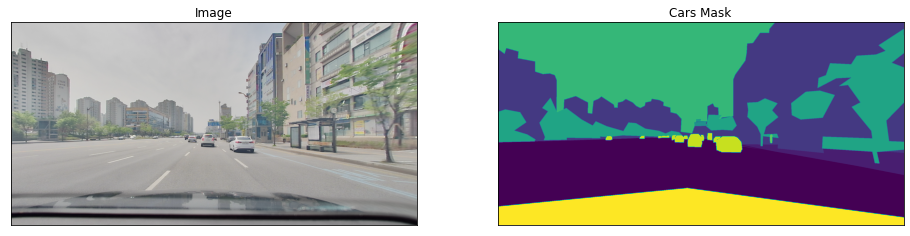

In [135]:
# Lets look at data we have

dataset = Dataset(csv_file='/home/work/CPS_Project/Samsung AI-Challenge/open/train_source.csv')

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [139]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),
        #albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def test_transform():
    transform = [
        albu.Resize(224,224),
        A.Normalize(),
        ToTensorV2()
    ]
    return albu.Compose(transform)

(320, 320)


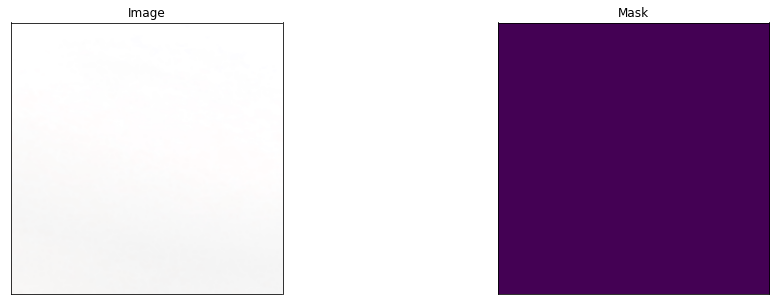

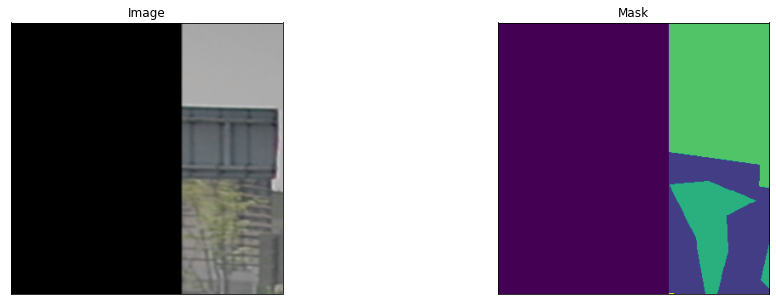

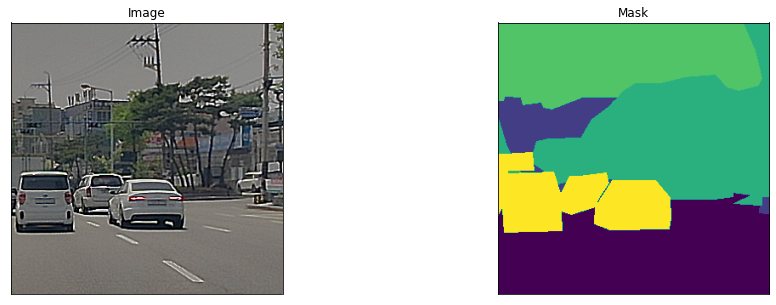

In [140]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    csv_file='/home/work/CPS_Project/Samsung AI-Challenge/open/train_source.csv', 
    augmentation=get_training_augmentation()
)
print(mask.shape)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[3]
    visualize(image=image, mask=mask)

In [ ]:
import sys

# 원하는 디렉토리 경로 추가
sys.path.append('/home/work/CPS_Project/Samsung AI-Challenge')

# 모듈 임포트
# from utils import your_util_function  # 필요한 함수 또는 클래스를 임포트

# 이제 해당 모듈의 함수나 클래스를 사용할 수 있습니다.

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
train_dataset = Dataset(
    csv_file='/home/work/CPS_Project/Samsung AI-Challenge/open/train_source.csv',
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    csv_file='/home/work/CPS_Project/Samsung AI-Challenge/open/val_source.csv', 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/home/work/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/work/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 20 epochs

max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './Samsung_best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 466/466 [00:42<00:00, 10.85it/s, dice_loss - 0.2059, iou_score - 0.7277]
Model saved!

Epoch: 1
valid: 100%|██████████| 466/466 [00:42<00:00, 10.86it/s, dice_loss - 0.4829, iou_score - 0.3998]

Epoch: 2
valid: 100%|██████████| 466/466 [00:43<00:00, 10.76it/s, dice_loss - 0.3379, iou_score - 0.5662]

Epoch: 3
valid: 100%|██████████| 466/466 [00:43<00:00, 10.74it/s, dice_loss - 0.06051, iou_score - 0.9205]
Model saved!

Epoch: 4
valid: 100%|██████████| 466/466 [00:43<00:00, 10.76it/s, dice_loss - 0.2088, iou_score - 0.7137]

Epoch: 5
valid: 100%|██████████| 466/466 [00:43<00:00, 10.77it/s, dice_loss - 0.06766, iou_score - 0.9132]

Epoch: 6
valid: 100%|██████████| 466/466 [00:43<00:00, 10.74it/s, dice_loss - 0.09075, iou_score - 0.8746]

Epoch: 7
valid: 100%|██████████| 466/466 [00:43<00:00, 10.73it/s, dice_loss - 0.08889, iou_score - 0.8853]

Epoch: 8
valid: 100%|██████████| 466/466 [00:43<00:00, 10.76it/s, dice_loss - 0.133, iou_score - 0.8221] 

Epoch:

In [ ]:
# load best saved checkpoint
best_model = torch.load('./Samsung_best_model.pth')

## Data Loader

## Define Model

## Model Train

## Inference

In [ ]:
transform = A.Compose(
    [   
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

test_dataset = Dataset(
    csv_file='/home/work/CPS_Project/Samsung AI-Challenge/open/test.csv', 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    test=test_transform(),
    classes=CLASSES,
    infer=True,
)

test_dataset = CustomDataset(csv_file='/home/work/CPS_Project/Samsung AI-Challenge/open/test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
with torch.no_grad():
    best_model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        outputs = model(images)
        outputs = torch.softmax(outputs, dim=1).cpu()
        outputs = torch.argmax(outputs, dim=1).numpy()
        # batch에 존재하는 각 이미지에 대해서 반복
        for pred in outputs:
            pred = pred.astype(np.uint8)
            pred = Image.fromarray(pred) # 이미지로 변환
            pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
            pred = np.array(pred) # 다시 수치로 변환
            # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
            for class_id in range(12):
                class_mask = (pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

  0%|          | 0/119 [00:00<?, ?it/s]/tmp/ipykernel_3148153/1383949781.py:13: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
100%|██████████| 119/119 [00:33<00:00,  3.58it/s]


## Submission

In [ ]:
submit = pd.read_csv('/home/work/CPS_Project/Samsung AI-Challenge/open/sample_submission.csv')
submit['mask_rle'] = result
submit

,id,mask_rle
0,TEST_0000_class_0,1 518400
1,TEST_0000_class_1,-1
2,TEST_0000_class_2,-1
3,TEST_0000_class_3,-1
4,TEST_0000_class_4,-1
...,...,...
22771,TEST_1897_class_7,-1
22772,TEST_1897_class_8,-1
22773,TEST_1897_class_9,-1
22774,TEST_1897_class_10,-1


In [ ]:
submit.to_csv('./baseline_submit_7(New_Model_2).csv', index=False)